In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import math
import json
from scipy.stats import mode

In [2]:
%matplotlib inline
%config InlineBackend.rc={'figure.figsize': (12, 8)}

# Params

In [3]:
# Execution params

folder_labels = 'Labels'

len_list_calc_normal = 40
len_list_calc_focus = 15

thresould_quantile = 1.5
jump_after_stimulus = 50

seconds_before_stimul = 2
seconds_after_stimul = 5
seconds_after_stimul_2 = 10

alter_to = 'median' # ['mode', 'median']

In [4]:
# Paths

path_exam_dataset = '/media/marcos/Dados/Projects/Datasets/Exams'
path_information = '/media/marcos/Dados/Projects/Datasets/Exams/Information_Exams'
path_labels = '/media/marcos/Dados/Projects/Results/PupilDeep/{}'.format(folder_labels)
path_out = '/media/marcos/Dados/Projects/Results/PupilDeep/{}/process'.format(folder_labels)

path_process_labels = '{}/process_labels'.format(path_out)
path_original_graphs = '{}/original_graphs'.format(path_out)
path_process_graphs = '{}/process_graphs'.format(path_out)

path_out_csv = '{}/process.csv'.format(path_out)
path_log = '{}/log.txt'.format(path_out)

# Funtions of treatment

In [5]:
def make_path(path_dir):
    try:
        os.mkdir(path_dir)
    except FileExistsError:
        pass

In [6]:
def remove_labels(path_remove):
    try:
        for file in os.listdir(path_remove):
            if ('.csv' in file) or ('.pdf' in file) or ('.txt' in file):
                remove = '{}/{}'.format(path_remove, file)
                os.remove(remove)
    except OSError as e:
        print("Failed with:", e.strerror) # look what it says
        print("Error code:", e.code)

In [7]:
def save_log(log):
    with open(path_log, 'a') as file_out:
        file_out.write('{}\n'.format(log))    

In [8]:
def create_csv_general(args):
    if len(args) != len(csv_out_header.split(',')):
        raise Exception('Numbers of paramns for generate full dataset is diferente of header!')
    
    args = [str(x).replace(',','-') for x in args]
    information = ','.join(args)
    with open(path_out_csv, 'a') as csv_out:
        csv_out.write('{}\n'.format(information))

In [9]:
def plot_graph(dataset, path_save_graph, title):
    title_graph = '{}\nlsrn: {}, lsrf: {}, tq: {}, at: {}, '.format(
        title, len_list_calc_normal, len_list_calc_focus, thresould_quantile, alter_to)
    
    img = dataset.plot.line(x='frame', y='radius', linestyle='-', markevery=100, marker='o', title=title)
    img.figure.savefig('{}/{}.pdf'.format(path_save_graph, title.replace('.csv', '')))

In [10]:
def calc_frame_stimul(time_stimul, fps_movie):
    stimul = time_stimul
    iMinuts = int(stimul[0:stimul.find(':')])
    iSeconds = int(stimul[stimul.find(':')+1:stimul.rfind(':')])
    iMilliseconds = int(stimul[stimul.rfind(':')+1:len(stimul)])
    frame = math.ceil((iMinuts*(fps_movie*60))+(iSeconds*fps_movie)+((iMilliseconds*fps_movie)/100))
    return frame

In [11]:
def get_information_exam(path_read_information, fps_movie): 
    patient, params, stimulus = '', '', []
    print(path_read_information)
    with open(path_read_information, 'r') as information:
        activate = False
        for line in information.readlines():            
            if 'PAC' in line:
                patient = line[line.rfind(':')+2:len(line)-1]
            if 'PRM' in line:
                param = line[line.rfind(':')+2:len(line)-1]
            if 'ATV' in line:
                stimul = line[line.rfind(':')+2:len(line)-1]
                init_stimul = calc_frame_stimul(line[0:line.rfind('-')-1], fps_movie)
                activate = not activate
            if 'DTV' in line:
                if activate:
                    activate = not activate
                    end_stimul = calc_frame_stimul(line[0:line.rfind('-')-1], fps_movie)
                    stimulus.append({'stimul': stimul,
                                     'init_stimul': init_stimul,
                                     'end_stimul': end_stimul})
    
    return patient, param, stimulus

In [12]:
def outlier_treatment(dataset):
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        list_radius = np.array([])
        list_radius = dataset.loc[frame:frame+len_list_calc_normal].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    return dataset

In [13]:
def treat_dataset(dataset, stimulus_treat):
    aux = 0
    for stimul in stimulus_treat:
        flash_dataset = dataset.loc[stimul['init_stimul']:stimul['end_stimul']]
        work_dataset = dataset.loc[aux:stimul['init_stimul']-1]

        frames_mod = mode(work_dataset['radius'])[0][0]
        frames_median = work_dataset['radius'].median()
        new_radius = frames_mod if alter_to == 'mode' else frames_median

        for index, item in flash_dataset.iterrows():
            dataset['radius'][index] = new_radius

        for index, item in work_dataset.iterrows():
            len_list = len_list_calc_normal
            if index > stimulus_treat[0]['init_stimul']:
                if index <= aux + jump_after_stimulus:
                    len_list = len_list_calc_focus

            range_dataset = work_dataset.loc[index:index+len_list]
            frames_mod = mode(range_dataset['radius'])[0][0]
            frames_median = range_dataset['radius'].median()
            new_radius = frames_mod if alter_to == 'mode' else frames_median
            dataset['radius'][index] = new_radius

    return dataset

In [14]:
def arrange_stimulus(dataset, stimulus_treat, fps_exam):
    limit = dataset.shape[0]
    stimulus = []
    for stimul in stimulus_treat:
        frame_before = math.ceil(stimul['init_stimul'] - (seconds_before_stimul * fps_exam))
        frame_after_1 = math.ceil(stimul['end_stimul'] + (seconds_after_stimul * fps_exam))
        frame_after_2 = math.ceil(stimul['end_stimul'] + (seconds_after_stimul_2 * fps_exam))
        
        frame_before = frame_before if frame_before >= 0 else 0
        frame_after_1 = frame_after_1 if frame_after_1 < limit else limit-1
        frame_after_2 = frame_after_2 if frame_after_2 < limit else limit-1
        
        before_stimulus = dataset['radius'][frame_before]
        after_stimulus_1 = dataset['radius'][frame_after_1]
        after_stimulus_2 = dataset['radius'][frame_after_2]
        
        aux = {'stimul' : str(stimul['stimul']), 'size_before_stimul': str(before_stimulus),
               'frame_init_stimul': str(stimul['init_stimul']), 'frame_end_stimul': str(stimul['end_stimul']),
               'size_after_{}_seconds'.format(seconds_after_stimul): str(after_stimulus_1),
               'size_after_{}_seconds'.format(seconds_after_stimul_2): str(after_stimulus_2)}
        
        stimulus.append(aux)
    
    return stimulus

# Init process of treatment label dataset

In [15]:
# Clear directories
make_path(path_out)
make_path(path_process_labels)
make_path(path_original_graphs)
make_path(path_process_graphs)

remove_labels(path_out)
remove_labels(path_process_labels)
remove_labels(path_original_graphs)
remove_labels(path_process_graphs)

In [16]:
list_labels = [x for x in os.listdir(path_labels) if '_label.csv' in x]
print('{}\n{}'.format(list_labels[0:3], len(list_labels)))

['07080107_08_2019_08_04_39_label.csv', '07080107_08_2019_08_05_48_label.csv', '07080207_08_2019_08_11_53_label.csv']
52


In [17]:
csv_out_header = 'patient,param,stimulus,eye_size,frame_meam,frame_std,frame_median'
print(csv_out_header)

patient,param,stimulus,eye_size,frame_meam,frame_std,frame_median


In [18]:
create_csv_general(csv_out_header.split(','))

/media/marcos/Dados/Projects/Datasets/Exams/Information_Exams/07080107_08_2019_08_04_39.log
(70801, 'RGBI= {78', 45)


TypeError: can only concatenate tuple (not "int") to tuple

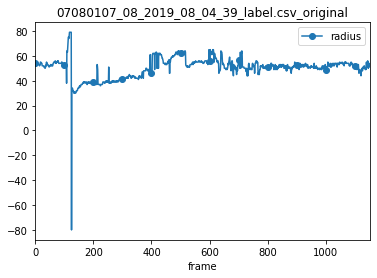

In [23]:
for label in list_labels:
    name_exam = label.replace('_label.csv', '')
    
    if 'benchmark' in name_exam:
        continue
    
    file_exam = '{}/{}.mp4'.format(path_exam_dataset, name_exam)    
    exam = cv2.VideoCapture(file_exam)    
    fps = exam.get(cv2.CAP_PROP_FPS)
    
    file_in = '{}/{}'.format(path_labels, label)
    file_out = '{}/{}'.format(path_process_labels, label)
    information = '{}/{}.log'.format(path_information, name_exam)
        
    patient, param, stimulus = get_information_exam(information, fps)
    
    if len(stimulus) <= 0:
        raise Exception('No exists stimuls in exam: {}'.format(name_exam))
    
    dataset = pd.read_csv(file_in)
    plot_graph(dataset, path_original_graphs, '%s_%s' % (label, 'original'))
    
    # dataset = outlier_treatment(dataset)
    
    # init
    
    Q1 = dataset['radius'].quantile(0.25)
    Q3 = dataset['radius'].quantile(0.75)
    IQR = Q3 - Q1    
    
    tq = thresould_quantile
    filter_q = (dataset['radius'] >= Q1 - tq * IQR) & (dataset['radius'] <= Q3 + tq * IQR)
    filter_q = [frame for frame, avaliable in filter_q.iteritems() if not avaliable]
    
    for frame in  filter_q:
        print(frame)
        list_radius = np.array([])
        list_radius = dataset.loc[frame:frame+len_list_calc_normal].radius
        dataset['radius'][frame] = int(np.median(list_radius))
    
    # end
    
    dataset = treat_dataset(dataset, stimulus)
    plot_graph(dataset, path_process_graphs, '%s_%s' % (label, 'treat'))    
    
    params_stimulus = arrange_stimulus(dataset, stimulus, fps)
    str_stimulus = [json.dumps(x) for x in params_stimulus]
        
    csv_parms = [patient, param, str_stimulus,dataset['eye_size'].mean(),
                 dataset['img_mean'].mean(),dataset['img_std'].mean(),
                 dataset['img_median'].mean()]
    
    create_csv_general(csv_parms)

    dataset.to_csv(file_out, index = False, header=True)